### Import Libraries

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [56]:
warnings.filterwarnings('ignore')
%matplotlib inline

#### Functions

In [57]:
def initialize_population( num_individuals, num_variables ):
    pop = np.random.randint(2, size=(num_individuals, num_variables))
    return pop

In [58]:
def crossover( pop ):
    num_individuals = len(pop)
    num_parameters = len(pop[0])
    indices = np.arange(num_individuals)

    np.random.shuffle(indices)
    offspring = []

    for i in range(0, num_individuals, 2):
        idx1 = indices[i]
        idx2 = indices[i+1]
        offspring1 = list(pop[idx1])
        offspring2 = list(pop[idx2])

        for idx in range(0, num_parameters):
            r = np.random.rand()
            if r < 0.5:
                temp = offspring2[idx]
                offspring2[idx] = offspring1[idx]
                offspring1[idx] = temp

        offspring.append(offspring1)
        offspring.append(offspring2)

    offspring = np.array(offspring)
    return offspring

In [59]:
def popop(objective, num_individuals, num_parameters, max_evaluations, algorithm):
    pop = initialize_population(num_individuals, num_parameters)
    po_pool_fitness = np.array([objective(ind) for ind in pop])
    num_evaluations = num_individuals
    best_fitness = []
    selection_size = num_individuals 
    
    while num_evaluations < max_evaluations:
        best_fitness.append([num_evaluations, np.max(po_pool_fitness)])
        offspring = crossover(pop)
        po_pool = np.vstack([pop, offspring])
        po_pool_fitness = np.array([objective(ind) for ind in po_pool])
        num_evaluations += len(offspring)
        selected_set = algorithm( po_pool, po_pool_fitness, selection_size)
        
        pop = selected_set


    best_fitness.append([num_evaluations, np.max(po_pool_fitness)])
    
    return (pop, po_pool_fitness, best_fitness)


In [60]:
def tune_population_size(problem_func, problem_name, param_size, seeds, max_eval, algorithms, num_inviduals):
    best_size = None
    best_avg = -np.inf
    algo_func = algorithms["Tournament Selection"] 
    for pop_size in num_inviduals:
        fitnesses = []
        for s in seeds:
            _, _, best_fitness = popop(problem_func, pop_size, param_size, max_eval, algo_func, s)
            final_fitness = [f[1] for f in best_fitness if f[0] <= max_eval][-1]
            fitnesses.append(final_fitness)
        avg_fitness = np.mean(fitnesses)
        print(f"Population size {pop_size}: Average fitness = {avg_fitness}")
        if avg_fitness > best_avg:
            best_avg = avg_fitness
            best_size = pop_size
    print(f"Best population size for {problem_name}: {best_size}")
    return best_size

In [61]:
def run_experiment(problem_func, problem_name, param_size, pop_size, seeds, max_eval, algorithms):
    results = {algo_name: [] for algo_name in algorithms.keys()}
    for algo_name, algo_func in algorithms.items():
        print(f"Running {algo_name} for {problem_name}...")
        for s in seeds:
            np.random.seed(s)
            _, _, best_fitness = popop(problem_func, pop_size, param_size, max_eval, algo_func)
            filtered = [f for f in best_fitness if f[0] <= max_eval]
            results[algo_name].append(filtered)
    
    plt.figure(figsize=(10, 6))
    for algo_name, data in results.items():
        all_evals = []
        all_fitness = []
        for run in data:
            evals = [f[0] for f in run]
            fitness = [f[1] for f in run]
            all_evals.append(evals)
            all_fitness.append(fitness)
        min_length = min(len(evals) for evals in all_evals)
        common_evals = all_evals[0][:min_length]
        trimmed_fitness = [f[:min_length] for f in all_fitness]
        avg_fitness = np.mean(trimmed_fitness, axis=0)
        std_fitness = np.std(trimmed_fitness, axis=0)
        plt.plot(common_evals, avg_fitness, label=algo_name)
        plt.fill_between(common_evals, avg_fitness - std_fitness, avg_fitness + std_fitness, alpha=0.2)
    plt.xlabel('Number of Evaluations')
    plt.ylabel('Fitness')
    plt.title(f'{problem_name} with {param_size} bit')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Algorithms

In [62]:
def truncation_selection(pop, pop_fitness, selection_size):
    selected_indices = np.argsort(pop_fitness)[-selection_size:]
    selected_set = pop[selected_indices]
    return selected_set

In [63]:
def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4):
    selected_set = []
    num_individuals = len(pop)
    for i in range(selection_size):
        tournament_indices = np.random.choice(num_individuals, tournament_size, replace=False)
        tournament_fitness = pop_fitness[tournament_indices]
        winner_idx = tournament_indices[np.argmax(tournament_fitness)]
        selected_set.append(pop[winner_idx])
    return selected_set

In [64]:
def proportional_selection ( pop, pop_fitness, selection_size):
    fitness = sum(pop_fitness)
    selection_prob = [f/fitness for f in pop_fitness]
    cumulative_prob = np.cumsum(selection_prob)
    selected_set = []

    for i in range(selection_size):
        r = np.random.rand()
        selected_index = np.searchsorted(cumulative_prob, r, side='right')
        selected_set.append(pop[selected_index])

    return selected_set

#### Benchmark

In [65]:
def onemax( ind ):
    value = np.sum(ind)
    return value

In [66]:
def leadingone( ind ):
    value = 0
    for i in ind:
        if i == 1:
            value += 1
        else:
            break
    return value

In [67]:
def concatenatedtrap_5( ind ):
    value = 0
    for i in range(0, len(ind), 5):
        sub = ind[i:i+5]
        sub_value = np.sum(sub)
        if sub_value == 5:
            value += 5
        else:
            value += 4 - sub_value
    return value

### Experiemnet

In [77]:
seed = [22520467 + i for i in range(0, 10)]
num_parameters = {
    "OneMax": 100,
    "Leading One": 20,
    "Concatenated Trap 5": 25
}
num_individuals = [8, 16, 32, 64, 128]
max_evaluations = 10000
algo = {
    "Truncation Selection": truncation_selection,
    "Tournament Selection": tournament_selection,
    "Proportional Selection": proportional_selection
}

In [78]:
# best_pop_onemax = tune_population_size(onemax, "OneMax", num_parameters["OneMax"], seed, max_evaluations, algo, num_individuals)
# print()
# best_pop_leadingone = tune_population_size(leadingone, "Leading One", num_parameters["Leading One"], seed, max_evaluations, algo, num_individuals)
# print()
# best_pop_trap = tune_population_size(concatenatedtrap_5, "Concatenated Trap 5", num_parameters["Concatenated Trap 5"], seed, max_evaluations, algo, num_individuals)

#### OneMax

Running Truncation Selection for OneMax...
Running Tournament Selection for OneMax...
Running Proportional Selection for OneMax...


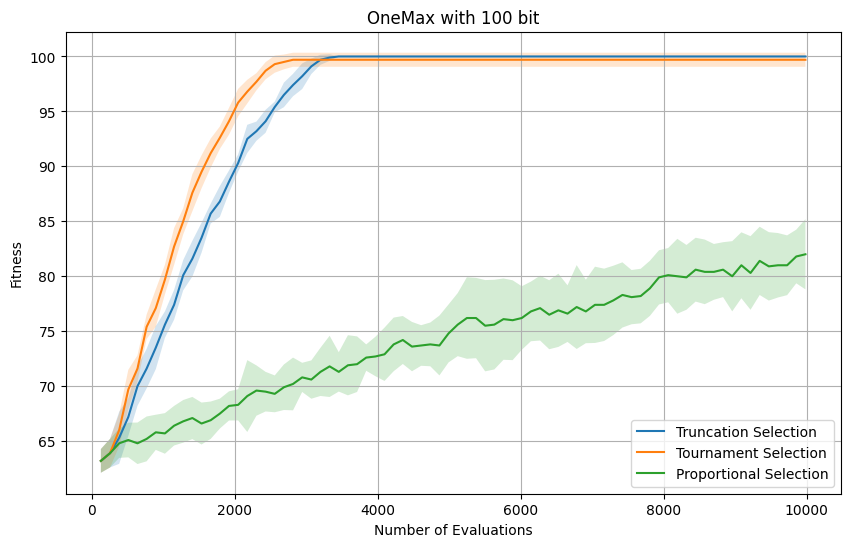

In [79]:
run_experiment(onemax, "OneMax", num_parameters["OneMax"], 128, seed, max_evaluations, algo)


Running Truncation Selection for Leading One...
Running Tournament Selection for Leading One...
Running Proportional Selection for Leading One...


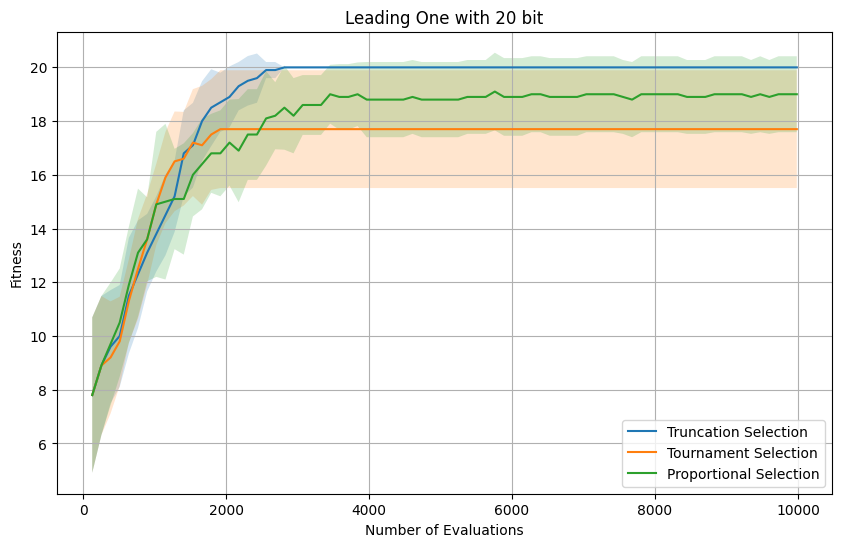

In [80]:
run_experiment(leadingone, "Leading One", num_parameters["Leading One"], 128, seed, max_evaluations, algo)


Running Truncation Selection for Concatenated Trap 5...
Running Tournament Selection for Concatenated Trap 5...
Running Proportional Selection for Concatenated Trap 5...


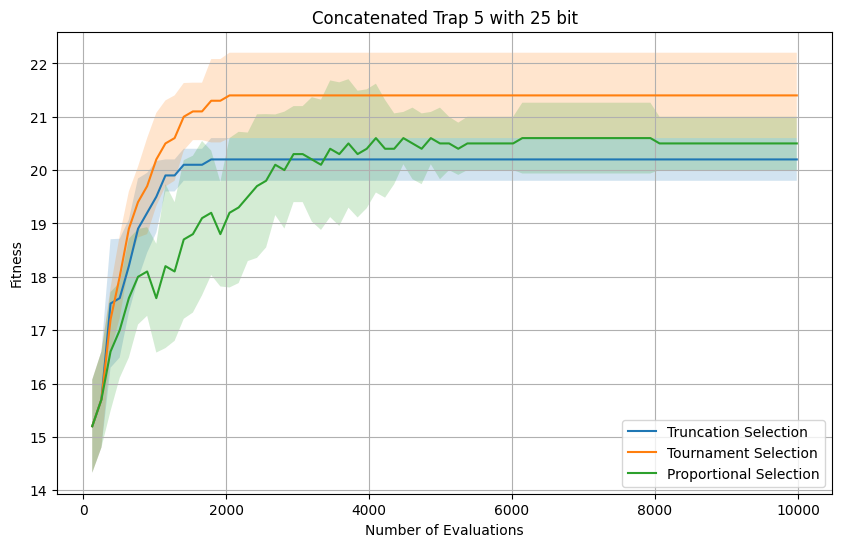

In [81]:
run_experiment(concatenatedtrap_5, "Concatenated Trap 5", num_parameters["Concatenated Trap 5"], 128, seed, max_evaluations, algo)

### Observation